In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

Reading Data

In [4]:
file_fold = r'C:\Users\AGNISH\Desktop\IITK\VSCode\SpatialGlue\Data\Mouse_Thymus'
gdata = sc.read_h5ad('adata_RNA.h5ad')
gdata.var_names_make_unique()

In [5]:
gdata

AnnData object with n_obs × n_vars = 4697 × 23622
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [6]:
file_fold = r'C:\Users\AGNISH\Desktop\IITK\VSCode\SpatialGlue\Data\Mouse_Thymus'
pdata = sc.read_h5ad('adata_ADT.h5ad')
pdata.var_names_make_unique()

In [7]:
pdata

AnnData object with n_obs × n_vars = 4697 × 51
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'

In [8]:
gdata.X

<4697x23622 sparse matrix of type '<class 'numpy.float64'>'
	with 5108108 stored elements in Compressed Sparse Row format>

In [9]:
pdata.X

<4697x51 sparse matrix of type '<class 'numpy.float64'>'
	with 70786 stored elements in Compressed Sparse Row format>

In [10]:
gdata.obs['orig.ident']

0_22    sample
0_33    sample
0_40    sample
0_41    sample
0_42    sample
         ...  
9_73    sample
9_74    sample
9_75    sample
9_8     sample
9_9     sample
Name: orig.ident, Length: 4697, dtype: category
Categories (1, object): ['sample']

In [11]:
#Normalization
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

In [12]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

In [13]:
gdata

AnnData object with n_obs × n_vars = 4697 × 23622
    obs: 'orig.ident', 'x', 'y'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'

In [14]:
pdata

AnnData object with n_obs × n_vars = 4697 × 51
    obs: 'orig.ident', 'x', 'y'
    uns: 'log1p'
    obsm: 'spatial'

Functions

In [15]:
import tensorflow as tf

class LinBnDrop(tf.keras.Sequential):
    def __init__(self, n_in, n_out, bn=True, p=0., act=None, lin_first=True):
        layers = []
        if bn:
            layers.append(tf.keras.layers.BatchNormalization())
        if p != 0:
            layers.append(tf.keras.layers.Dropout(p))
        lin = [tf.keras.layers.Dense(n_out, use_bias=not bn)]
        if act is not None:
            layers.append(act)
        layers = lin + layers if lin_first else layers + lin
        super(LinBnDrop, self).__init__(layers)


In [16]:
# This is the block without the Variational AE Loss

# import tensorflow as tf
# import tensorflow.compat.v1 as v1
# import torch


# class GATE():
#     def __init__(self, hidden_dims1, hidden_dims2,z_dim=30,alpha=0.8, nonlinear=True, weight_decay=0.0001, temperature=1.0):
#         self.n_layers1 = len(hidden_dims1) - 1
#         self.n_layers2 = len(hidden_dims2) - 1
#         self.alpha = alpha
#         self.W1, self.v1, self.prune_v1 = self.define_weights1(hidden_dims1, self.n_layers1)
#         self.W2, self.v2, self.prune_v2 = self.define_weights2(hidden_dims2, self.n_layers2)
#         self.C1 = {}
#         self.C2 = {}
#         self.prune_C1 = {}
#         self.prune_C2 = {}
#         self.nonlinear = nonlinear
#         self.weight_decay = weight_decay
#         self.z_dim = z_dim
#         self.temperature = temperature
#         self.clip_loss = 0

#         # X1 and X2 are the original dataframes of Gene Expression and Protein respectively
#         # H1 and H2 are the individual latent spaces after passing through the encoders
#         # H is the combined latent space after passing through the third encoder
#         # X1_ and X2_ are the decoder outputs

#         # Decoder 1
#         self.W_dec1 = {}
#         for layer in range(self.n_layers1 - 1, -1, -1):
#             self.W_dec1[layer] = tf.Variable(tf.random.normal([hidden_dims1[layer+1], hidden_dims1[layer]]))

#         # Decoder 2
#         self.W_dec2 = {}
#         for layer in range(self.n_layers2 - 1, -1, -1):
#             self.W_dec2[layer] = tf.Variable(tf.random.normal([hidden_dims2[layer+1], hidden_dims2[layer]]))

#     def __call__(self, A1,A2 ,prune_A, X1,X2):

#         clip_loss = self.clip_loss

#         # Encoder 1
#         H1 = X1
#         for layer in range(self.n_layers1):
#             H1 = self.__encoder1(A1, prune_A, H1, layer)
#             if self.nonlinear:
#                 if layer != self.n_layers1 - 1:
#                     H1 = tf.nn.elu(H1)

#         # Encoder 2
#         H2 = X2
#         for layer in range(self.n_layers2):
#             H2 = self.__encoder2(A2, prune_A, H2, layer)
#             if self.nonlinear:
#                 if layer != self.n_layers2 - 1:
#                     H2 = tf.nn.elu(H2)

#         # Loss Calculation using clip

#         gene_embeddings = H1
#         protein_embeddings= H2
#         # global clip_loss
#         # clip_loss=0

#         # logits[i][j] is the dot_similarity(protein_i, gene_j).
#         logits = (tf.matmul(gene_embeddings, protein_embeddings, transpose_b=True) / self.temperature)
        
#         # gene_similarity[i][j] is the dot_similarity(gene_i, gene_j).
#         gene_similarity = tf.matmul(gene_embeddings, gene_embeddings, transpose_b=True)
        
#         # protein_similarity[i][j] is the dot_similarity(protein_i, protein_j).
#         protein_similarity = tf.matmul(protein_embeddings, protein_embeddings, transpose_b=True)
        
#         # targets[i][j] = avarage dot_similarity(protein_i, protein_j) and dot_similarity(gene_i, gene_j).
#         targets = tf.keras.activations.softmax((protein_similarity + gene_similarity) / (2 * self.temperature))

#         # Compute the loss for the captions using crossentropy
#         gene_loss = tf.keras.losses.categorical_crossentropy(y_true=targets, y_pred=logits, from_logits=True)
        
#         # Compute the loss for the images using crossentropy
#         protein_loss = tf.keras.losses.categorical_crossentropy(y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True)
        
#         # Return the mean of the loss over the batch.
#         loss_clip = (protein_loss + gene_loss) / 2

#         clip_loss = tf.reduce_mean(loss_clip)

#         self.c_loss = clip_loss


#         # Concatenate encoder outputs
#         H = tf.concat([H1, H2], axis=1)

#         # Call the third encoder
#         global latent_rep 
#         H = self.__encoder3(H)
        
#         latent_rep = H

#         temp=H
#         H1=temp
#         # Decoder 1
#         for layer in range(self.n_layers1 - 1, -1, -1):
#             H1 = self.__decoder1(H1, layer)
#             if self.nonlinear:
#                 if layer != 0:
#                     H1 = tf.nn.elu(H1)
#         X1_ = H1

#         H2=temp
#         # Decoder 2
#         for layer1 in range(self.n_layers2 - 1, -1, -1):
#             H2 = self.__decoder2(H2, layer1)
#             if self.nonlinear:
#                 if layer1 != 0:
#                     H2 = tf.nn.elu(H2)
#         X2_ = H2


#         # Loss calculation
#         features_loss = tf.sqrt(tf.reduce_sum(tf.pow(X1 - X1_, 2)))
#         features_loss += tf.sqrt(tf.reduce_sum(tf.pow(X2 - X2_, 2)))

#         weight_decay_loss = 0
#         for layer in range(self.n_layers1):
#             weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W1[layer]), self.weight_decay, name='weight_loss')
#         for layer in range(self.n_layers2):
#             weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W2[layer]), self.weight_decay, name='weight_loss')
#         for layer in range(self.n_layers1):
#             weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec1[layer]), self.weight_decay, name='weight_loss')
#         for layer in range(self.n_layers2):
#             weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec2[layer]), self.weight_decay, name='weight_loss')

#         # Total loss
#         W_C = 1
#         W_R = 1
#         self.loss = W_C*(clip_loss) + W_R*(features_loss + weight_decay_loss)

#         if self.alpha == 0:

            
#             self.Att_l = {'C1': self.C1, 'C2': self.C2}
#         else:
#             self.Att_l = {'C1': self.C1, 'C2': self.C2, 'prune_C1': self.prune_C1, 'prune_C2': self.prune_C2}
#         return  self.c_loss, self.loss, H, self.Att_l, X1_, X2_
    
#     def __encoder1(self, A, prune_A, H, layer):
#         print('enc1 = ',H)
#         H = tf.matmul(H, self.W1[layer])
#         if layer == self.n_layers1 - 1:
#             return H
#         self.C1[layer] = self.graph_attention_layer(A, H, self.v1[layer], layer)
#         if self.alpha == 0:
#             return tf.sparse.sparse_dense_matmul(self.C1[layer], H)
#         else:
#             self.prune_C1[layer] = self.graph_attention_layer(prune_A, H, self.prune_v1[layer], layer)
#             return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
#                 self.prune_C1[layer], H)
        
        

#     def __encoder2(self, A, prune_A, H, layer):
#         print('enc2 = ',H)
#         H = tf.matmul(H, self.W2[layer])
#         if layer == self.n_layers2 - 1:
#             return H
#         self.C2[layer] = self.graph_attention_layer(A, H, self.v2[layer], layer)
#         if self.alpha == 0:
#             return tf.sparse.sparse_dense_matmul(self.C2[layer], H)
#         else:
#             self.prune_C2[layer] = self.graph_attention_layer(prune_A, H, self.prune_v2[layer], layer)
#             return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
#                 self.prune_C2[layer], H)
    
#     def __decoder1(self, H, layer):
#         print('dec1 = ',H)
#         H = tf.matmul(H, self.W1[layer], transpose_b=True)
#         if layer == 0:

#             return H
#         if self.alpha == 0:

#             return tf.sparse.sparse_dense_matmul(self.C1[layer-1], H)
#         else:

#             return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
#                 self.prune_C1[layer-1], H)
        
#     def __decoder2(self, H, layer):
#         print('dec2 = ',H)
#         H = tf.matmul(H, self.W2[layer], transpose_b=True)
#         if layer == 0:

#             return H
#         if self.alpha == 0:
#             return tf.sparse.sparse_dense_matmul(self.C2[layer-1], H)
        
#         else:

#             return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
#                 self.prune_C2[layer-1], H)
        

#     def __encoder3(self, H):
#         print('enc3 = ',H)
#         H = tf.keras.layers.Dense(self.z_dim)(H)
#         print('LATENT = ',H)
#         return H


#     def define_weights1(self,hidden_dims,n_layers):
#         W = {}
#         #print('TOTAL LEYRS = ',n_layers)
#         #n_layers=len(n_layers)-1
#         print('n_layers gene = ',n_layers)
#         print('Hidden dim gene = ',hidden_dims)

#         for i in range(n_layers):
#             W[i] = v1.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

#         Ws_att = {}
#         for i in range(n_layers-1):
#             V= {}
#             V[0] = v1.get_variable("V%s_0" % i, shape=(hidden_dims[i+1], 1))
#             V[1] = v1.get_variable("V%s_1" % i, shape=(hidden_dims[i+1], 1))

#             Ws_att[i] = V
#         if self.alpha == 0:
#             return W, Ws_att, None
#         prune_Ws_att = {}
#         for i in range(n_layers-1):
#             prune_V = {}
#             prune_V[0] = v1.get_variable("prune_V%s_0" % i, shape=(hidden_dims[i+1], 1))
#             prune_V[1] = v1.get_variable("prune_V%s_1" % i, shape=(hidden_dims[i+1], 1))

#             prune_Ws_att[i] = prune_V

#         return W, Ws_att, prune_Ws_att
    
#     def define_weights2(self,hidden_dims,n_layers):
#         w = {}
#         #print('TOTAL LEYRS = ',n_layers)
#         #n_layers=len(n_layers)-1
#         print('n_layers protein = ',n_layers)
#         print('Hidden dim protein = ',hidden_dims)

#         for i in range(n_layers):
#             w[i] = v1.get_variable("w%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

#         ws_att = {}
#         for i in range(n_layers-1):
#             v = {}
#             v[0] = v1.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
#             v[1] = v1.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

#             ws_att[i] = v
#         if self.alpha == 0:
#             return w, ws_att, None
#         prune_ws_att = {}
#         for i in range(n_layers-1):
#             prune_v = {}
#             prune_v[0] = v1.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
#             prune_v[1] = v1.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

#             prune_ws_att[i] = prune_v

#         return w, ws_att, prune_ws_att
    


#     def graph_attention_layer(self, A, M, v, layer):

#         with v1.variable_scope("layer_%s" % layer):
#             f1 = tf.matmul(M, v[0])
#             f1 = A * f1
#             f2 = tf.matmul(M, v[1])
#             f2 = A * tf.transpose(f2, [1, 0])
#             logits = v1.sparse_add(f1, f2)

#             unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
#                                          values=tf.nn.sigmoid(logits.values),
#                                          dense_shape=logits.dense_shape)
#             attentions = v1.sparse_softmax(unnormalized_attentions)

#             attentions = tf.SparseTensor(indices=attentions.indices,
#                                          values=attentions.values,
#                                          dense_shape=attentions.dense_shape)

#             return attentions

In [17]:
import tensorflow as tf
import tensorflow.compat.v1 as v1


class GATE():
    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, a=0.5, alpha=0.8, nonlinear=True, weight_decay=0.0001, temperature=1.0):
        self.n_layers1 = len(hidden_dims1) - 1
        self.n_layers2 = len(hidden_dims2) - 1
        self.alpha = alpha
        self.W1, self.v1, self.prune_v1 = self.define_weights1(hidden_dims1, self.n_layers1)
        self.W2, self.v2, self.prune_v2 = self.define_weights2(hidden_dims2, self.n_layers2)
        self.C1 = {}
        self.C2 = {}
        self.prune_C1 = {}
        self.prune_C2 = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay
        self.z_dim = z_dim
        self.temperature = temperature
        self.clip_loss = 0
        self.fc_mu = LinBnDrop(z_dim,z_dim, p=0.2)
        self.fc_var = LinBnDrop(z_dim,z_dim, p=0.2)
        self.a = a

        # X1 and X2 are the original dataframes of Gene Expression and Protein respectively
        # H1 and H2 are the individual latent spaces after passing through the encoders
        # H is the combined latent space after passing through the third encoder
        # X1_ and X2_ are the decoder outputs

        # Decoder 1
        self.W_dec1 = {}
        for layer in range(self.n_layers1 - 1, -1, -1):
            self.W_dec1[layer] = tf.Variable(tf.random.normal([hidden_dims1[layer+1], hidden_dims1[layer]]))

        # Decoder 2
        self.W_dec2 = {}
        for layer in range(self.n_layers2 - 1, -1, -1):
            self.W_dec2[layer] = tf.Variable(tf.random.normal([hidden_dims2[layer+1], hidden_dims2[layer]]))

    def __call__(self, A1,A2 ,prune_A, X1,X2):

        clip_loss = self.clip_loss

        # Encoder 1
        H1 = X1
        for layer in range(self.n_layers1):
            H1 = self.__encoder1(A1, prune_A, H1, layer)
            if self.nonlinear:
                if layer != self.n_layers1 - 1:
                    H1 = tf.nn.elu(H1)

        # Encoder 2
        H2 = X2
        for layer in range(self.n_layers2):
            H2 = self.__encoder2(A2, prune_A, H2, layer)
            if self.nonlinear:
                if layer != self.n_layers2 - 1:
                    H2 = tf.nn.elu(H2)

        # Loss Calculation using clip

        gene_embeddings = H1
        protein_embeddings= H2
        # global clip_loss
        # clip_loss=0

        # logits[i][j] is the dot_similarity(protein_i, gene_j).
        logits = (tf.matmul(gene_embeddings, protein_embeddings, transpose_b=True) / self.temperature)
        
        # gene_similarity[i][j] is the dot_similarity(gene_i, gene_j).
        gene_similarity = tf.matmul(gene_embeddings, gene_embeddings, transpose_b=True)
        
        # protein_similarity[i][j] is the dot_similarity(protein_i, protein_j).
        protein_similarity = tf.matmul(protein_embeddings, protein_embeddings, transpose_b=True)
        
        # targets[i][j] = avarage dot_similarity(protein_i, protein_j) and dot_similarity(gene_i, gene_j).
        targets = tf.keras.activations.softmax((protein_similarity + gene_similarity) / (2 * self.temperature))

        # Compute the loss for the captions using crossentropy
        gene_loss = tf.keras.losses.categorical_crossentropy(y_true=targets, y_pred=logits, from_logits=True)
        
        # Compute the loss for the images using crossentropy
        protein_loss = tf.keras.losses.categorical_crossentropy(y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True)
        
        # Return the mean of the loss over the batch.
        loss_clip = (protein_loss + gene_loss) / 2

        clip_loss = tf.reduce_mean(loss_clip)

        self.c_loss = clip_loss


        # Concatenate encoder outputs
        H = tf.concat([H1, H2], axis=1)

        # Call the third encoder
        global latent_rep 
        H = self.__encoder3(H)

        #Latent space using a varational auto encoder
        mu = self.fc_mu(H)
        var = self.fc_var(H)
        H = self.reparameterize(mu, var)
        
        latent_rep = H

        # KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(1 + var - tf.square(mu) - tf.exp(var), axis=1)
        kl_loss = tf.reduce_mean(kl_loss)


        temp=H
        H1=temp
        # Decoder 1
        for layer in range(self.n_layers1 - 1, -1, -1):
            H1 = self.__decoder1(H1, layer)
            if self.nonlinear:
                if layer != 0:
                    H1 = tf.nn.elu(H1)
        X1_ = H1

        H2=temp
        # Decoder 2
        for layer1 in range(self.n_layers2 - 1, -1, -1):
            H2 = self.__decoder2(H2, layer1)
            if self.nonlinear:
                if layer1 != 0:
                    H2 = tf.nn.elu(H2)
        X2_ = H2

        # Loss calculation
        features_loss = tf.sqrt(tf.reduce_sum(tf.pow(X1 - X1_, 2)))
        features_loss += tf.sqrt(tf.reduce_sum(tf.pow(X2 - X2_, 2)))


        weight_decay_loss = 0
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W2[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec2[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        W_C = -10
        W_R = 1
        self.loss = W_C*(clip_loss) + W_R*(features_loss + weight_decay_loss + self.a*kl_loss)
        print("clip loss = ",clip_loss)
        # self.loss = W_C*(clip_loss) + W_R*(features_loss + weight_decay_loss)

        if self.alpha == 0:
            self.Att_l = {'C1': self.C1, 'C2': self.C2}
        else:
            self.Att_l = {'C1': self.C1, 'C2': self.C2, 'prune_C1': self.prune_C1, 'prune_C2': self.prune_C2}
        return  self.c_loss, self.loss, H, self.Att_l, X1_, X2_
    

    def reparameterize(self, mu, logvar):
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(shape=tf.shape(std))
        return eps * std + mu
    
    def __encoder1(self, A, prune_A, H, layer):
        print('enc1 = ',H)
        H = tf.matmul(H, self.W1[layer])
        if layer == self.n_layers1 - 1:
            return H
        self.C1[layer] = self.graph_attention_layer(A, H, self.v1[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C1[layer], H)
        else:
            self.prune_C1[layer] = self.graph_attention_layer(prune_A, H, self.prune_v1[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer], H)
        
        

    def __encoder2(self, A, prune_A, H, layer):
        print('enc2 = ',H)
        H = tf.matmul(H, self.W2[layer])
        if layer == self.n_layers2 - 1:
            return H
        self.C2[layer] = self.graph_attention_layer(A, H, self.v2[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer], H)
        else:
            self.prune_C2[layer] = self.graph_attention_layer(prune_A, H, self.prune_v2[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer], H)
    
    def __decoder1(self, H, layer):
        print('dec1 = ',H)
        H = tf.matmul(H, self.W1[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:

            return tf.sparse.sparse_dense_matmul(self.C1[layer-1], H)
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer-1], H)
        
    def __decoder2(self, H, layer):
        print('dec2 = ',H)
        H = tf.matmul(H, self.W2[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer-1], H)
        
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer-1], H)
        

    def __encoder3(self, H):
        print('enc3 = ',H)
        H = tf.keras.layers.Dense(self.z_dim)(H)
        print('LATENT = ',H)
        return H


    def define_weights1(self,hidden_dims,n_layers):
        W = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers gene = ',n_layers)
        print('Hidden dim gene = ',hidden_dims)

        for i in range(n_layers):
            W[i] = v1.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(n_layers-1):
            V= {}
            V[0] = v1.get_variable("V%s_0" % i, shape=(hidden_dims[i+1], 1))
            V[1] = v1.get_variable("V%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = V
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(n_layers-1):
            prune_V = {}
            prune_V[0] = v1.get_variable("prune_V%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_V[1] = v1.get_variable("prune_V%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_V

        return W, Ws_att, prune_Ws_att
    
    def define_weights2(self,hidden_dims,n_layers):
        w = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers protein = ',n_layers)
        print('Hidden dim protein = ',hidden_dims)

        for i in range(n_layers):
            w[i] = v1.get_variable("w%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        ws_att = {}
        for i in range(n_layers-1):
            v = {}
            v[0] = v1.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = v1.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            ws_att[i] = v
        if self.alpha == 0:
            return w, ws_att, None
        prune_ws_att = {}
        for i in range(n_layers-1):
            prune_v = {}
            prune_v[0] = v1.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = v1.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_ws_att[i] = prune_v

        return w, ws_att, prune_ws_att
    


    def graph_attention_layer(self, A, M, v, layer):

        with v1.variable_scope("layer_%s" % layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = v1.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = v1.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions

In [18]:
# import tensorflow as tf
# import scipy.sparse as sp
# import numpy as np
# #from .model import GATE
# import tensorflow.compat.v1 as v1
# from tqdm import tqdm

# class STAGATE():

#     def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, alpha=0, n_epochs=500, lr=0.0001, 
#                  gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
#                  verbose=True, random_seed=2020, temperature=1.0
#                  ):
        
#         np.random.seed(random_seed)
#         tf.random.set_seed(random_seed)
#         self.loss_list = []
#         self.lr = lr
#         self.n_epochs = n_epochs
#         self.gradient_clipping = gradient_clipping
#         self.build_placeholders()
#         self.verbose = verbose
#         self.alpha = alpha
           

#         self.gate = GATE(hidden_dims1,hidden_dims2,z_dim,alpha, nonlinear, weight_decay, temperature)
#         self.c_loss, self.loss, self.H, self.C, self.ReX1, self.ReX2 = self.gate(self.A1,self.A2, self.prune_A, self.X1,self.X2)
#         #print(self.loss, self.H, self.C, self.ReX1, self.ReX2,sep='\n')

#         self.optimize(self.loss)
#         self.build_session()

#     def build_placeholders(self):
#         self.A1 = v1.sparse_placeholder(dtype=tf.float32)
#         self.A2 = v1.sparse_placeholder(dtype=tf.float32)
#         self.prune_A = v1.sparse_placeholder(dtype=tf.float32)
#         self.X1 = v1.placeholder(dtype=tf.float32)
#         self.X2 = v1.placeholder(dtype=tf.float32)


#     def build_session(self, gpu= True):
#         config = v1.ConfigProto()
#         config.gpu_options.allow_growth = True
#         if gpu == False:
#             config.intra_op_parallelism_threads = 0
#             config.inter_op_parallelism_threads = 0
#         self.session = v1.Session(config=config)
#         self.session.run([v1.global_variables_initializer(), v1.local_variables_initializer()])

#     def optimize(self, loss):
#         optimizer = v1.train.AdamOptimizer(learning_rate=self.lr)
#         gradients, variables = zip(*optimizer.compute_gradients(loss))
#         gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
#         self.train_op = optimizer.apply_gradients(zip(gradients, variables))

#     def __call__(self, A1, A2, prune_A, X1, X2):
#         for epoch in range(self.n_epochs):
#             self.run_epoch(epoch, A1, A2, prune_A, X1, X2)




#     def run_epoch(self, epoch, A1,A2 ,prune_A, X1,X2):

#         c_loss, loss, _ = self.session.run([self.c_loss, self.loss, self.train_op],
#                            feed_dict={self.A1: A1,
#                                       self.A2: A2,
#                                       self.prune_A: prune_A,
#                                       self.X1: X1,
#                                       self.X2: X2})

#         self.loss_list.append(loss)
#         if self.verbose:
#             print("Epoch: %s, C_loss:%.4f, Loss:%.4f" % (epoch, c_loss, loss))
            
#         return loss

#     def infer(self, A1,A2, prune_A, X1,X2):
#         global C
#         H, C, ReX1, ReX2 = self.session.run([self.H, self.C, self.ReX1, self.ReX2],
#                                     feed_dict={self.A1: A1,
#                                                self.A2: A2,
#                                                self.prune_A: prune_A,
#                                                self.X1: X1,
#                                                self.X2: X2})

        
#         return H, self.Conbine_Atten_l(C['C1']), self.loss_list, ReX1,ReX2

#     def Conbine_Atten_l(self, input):
#         if self.alpha == 0:
#             return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
#         else:
#             Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
#             Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
#             return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]

In [19]:
import tensorflow as tf
import scipy.sparse as sp
import numpy as np
#from .model import GATE
import tensorflow.compat.v1 as v1
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, alpha=0, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020,
                 ):
        
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
           

        self.gate = GATE(hidden_dims1,hidden_dims2,z_dim,alpha, nonlinear, weight_decay)
        self.c_loss,self.loss, self.H, self.C, self.ReX1, self.ReX2 = self.gate(self.A1,self.A2, self.prune_A, self.X1,self.X2)
        #print(self.loss, self.H, self.C, self.ReX1, self.ReX2,sep='\n')

        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A1 = v1.sparse_placeholder(dtype=tf.float32)
        self.A2 = v1.sparse_placeholder(dtype=tf.float32)
        self.prune_A = v1.sparse_placeholder(dtype=tf.float32)
        self.X1 = v1.placeholder(dtype=tf.float32)
        self.X2 = v1.placeholder(dtype=tf.float32)


    def build_session(self, gpu= True):
        config = v1.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = v1.Session(config=config)
        self.session.run([v1.global_variables_initializer(), v1.local_variables_initializer()])

    def optimize(self, loss):
        optimizer = v1.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A1, A2, prune_A, X1, X2):
        for epoch in range(self.n_epochs):
            self.run_epoch(epoch, A1, A2, prune_A, X1, X2)




    def run_epoch(self, epoch, A1,A2 ,prune_A, X1,X2):

        c_loss, loss, _ = self.session.run([self.c_loss, self.loss, self.train_op],
                           feed_dict={self.A1: A1,
                                      self.A2: A2,
                                      self.prune_A: prune_A,
                                      self.X1: X1,
                                      self.X2: X2})

        self.loss_list.append(loss)
        if self.verbose:
            print("Epoch: %s, Loss: %.4f, Clip Loss: %.4f" % (epoch, loss,c_loss))
            
            
        return loss

    def infer(self, A1,A2, prune_A, X1,X2):
        global C
        H, C, ReX1, ReX2 = self.session.run([self.H, self.C, self.ReX1, self.ReX2],
                                    feed_dict={self.A1: A1,
                                               self.A2: A2,
                                               self.prune_A: prune_A,
                                               self.X1: X1,
                                               self.X2: X2})

        
        return H, self.Conbine_Atten_l(C['C1']), self.loss_list, ReX1,ReX2

    def Conbine_Atten_l(self, input):
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
            Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]


In [20]:
import numpy as np
import scipy.sparse as sp
#from .STAGATE import STAGATE
import tensorflow as tf
import pandas as pd
import scanpy as sc

def train_STAGATE(adata1,adata2, 
                hidden_dims1=[512, 30],hidden_dims2=[512, 30],z_dim=30, alpha=0, n_epochs=500, lr=0.0001, key_added='MY_ARCH',
                gradient_clipping=5, nonlinear=True, weight_decay=0.0001,verbose=True, 
                random_seed=2020, pre_labels=None, pre_resolution=0.2,
                save_attention=False, save_loss=False, save_reconstrction=False
                ):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    #tf.reset_default_graph()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    if 'highly_variable' in adata1.var.columns:
        adata_Vars1 =  adata1[:, adata1.var['highly_variable']]
    else:
        adata_Vars1 = adata1
    X1 = pd.DataFrame(adata_Vars1.X[:, ].toarray(), index=adata_Vars1.obs.index, columns=adata_Vars1.var.index)

    
    if 'highly_variable' in adata2.var.columns:
        adata_Vars2 =  adata2[:, adata2.var['highly_variable']]
    else:
        adata_Vars2 = adata2
    X2 = pd.DataFrame(adata_Vars2.X[:, ].toarray(), index=adata_Vars2.obs.index, columns=adata_Vars2.var.index)

    if verbose:
        print('Size of Input for gene data : ', adata_Vars1.shape)
        print('Size of Input for protein data : ',adata_Vars2.shape)



    cells1 = np.array(X1.index)
    cells_id_tran1 = dict(zip(cells1, range(cells1.shape[0])))
    if 'Spatial_Net' not in adata1.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")

    Spatial_Net1 = adata1.uns['Spatial_Net']
    G_df1 = Spatial_Net1.copy()
    G_df1['Cell1'] = G_df1['Cell1'].map(cells_id_tran1)
    G_df1['Cell2'] = G_df1['Cell2'].map(cells_id_tran1)
    G1 = sp.coo_matrix((np.ones(G_df1.shape[0]), (G_df1['Cell1'], G_df1['Cell2'])), shape=(adata1.n_obs, adata1.n_obs))
    global G_tf1
    G_tf1 = prepare_graph_data(G1)

    cells2 = np.array(X2.index)
    cells_id_tran2 = dict(zip(cells2, range(cells2.shape[0])))
    if 'Spatial_Net' not in adata2.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net2 = adata1.uns['Spatial_Net']
    G_df2 = Spatial_Net2.copy()
    G_df2['Cell1'] = G_df2['Cell1'].map(cells_id_tran2)
    G_df2['Cell2'] = G_df2['Cell2'].map(cells_id_tran2)
    G2 = sp.coo_matrix((np.ones(G_df2.shape[0]), (G_df2['Cell1'], G_df2['Cell2'])), shape=(adata2.n_obs, adata2.n_obs))
    global G_tf2
    G_tf2 = prepare_graph_data(G2)

    tf.compat.v1.disable_eager_execution()
    trainer = STAGATE(hidden_dims1=[X1.shape[1]] + hidden_dims1,hidden_dims2=[X2.shape[1]] + hidden_dims2, z_dim=z_dim,alpha=alpha, 
                    n_epochs=n_epochs, lr=lr, gradient_clipping=gradient_clipping, 
                    nonlinear=nonlinear,weight_decay=weight_decay, verbose=verbose, 
                    random_seed=random_seed                    
                    )
    

    print("START TRAIN")
    
    #explain the code from here
    if alpha == 0:
        trainer(G_tf1, G_tf2, G_tf1, X1,X2)
        embeddings, attentions, loss, ReX1, ReX2= trainer.infer(G_tf1, G_tf2, G_tf1, X1,X2)
    else:
        G_df1 = Spatial_Net1.copy()
        if pre_labels==None:
            if verbose:
                print('------Pre-clustering adata1 using louvain with resolution=%.2f' %pre_resolution)
            sc.tl.pca(adata1, svd_solver='arpack')
            sc.pp.neighbors(adata1)
            sc.tl.louvain(adata1, resolution=pre_resolution, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df1, adata1.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran1)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran1)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf1[2])
        trainer(G_tf1, prune_G_tf, X1)
        embeddings, attentions, loss, ReX1, ReX2 = trainer.infer(G_tf1,G_tf2, prune_G_tf, X1,X2)

    global df
    cell_reps = pd.DataFrame(embeddings)
    df=cell_reps
    cell_reps.index = cells1

    adata1.obsm[key_added] = cell_reps.loc[adata1.obs_names, ].values
    if save_attention:
        adata1.uns['arch_attention'] = attentions
    if save_loss:
        adata1.uns['arch_loss'] = loss
    if save_reconstrction:
        ReX1 = pd.DataFrame(ReX1, index=X1.index, columns=X1.columns)
        ReX1[ReX1<0] = 0
        adata1.layers['arch_ReX1'] = ReX1.values
        ReX2 = pd.DataFrame(ReX2, index=X2.index, columns=X2.columns)
        ReX2[ReX2<0] = 0
        adata2.layers['archE_ReX2'] = ReX2.values

    return adata1




def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX1' in adata.uns)
    temp_df = adata.uns['ReX1'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count1'] = temp_df
    
    assert('ReX2' in adata.uns)
    temp_df = adata.uns['ReX2'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count2'] = temp_df

    return adata

    


In [21]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='MY_ARCH', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

------Calculating spatial graph...


The graph contains 18316 edges, 4697 cells.
3.8995 neighbors per cell on average.


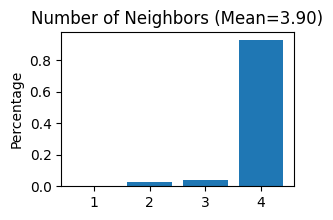

In [22]:
Cal_Spatial_Net(gdata, rad_cutoff=100)
Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 18316 edges, 4697 cells.
3.8995 neighbors per cell on average.


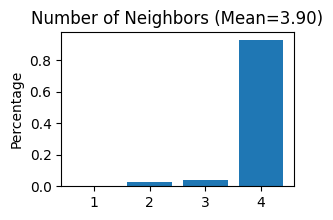

In [23]:
Cal_Spatial_Net(pdata, rad_cutoff=100)
Stats_Spatial_Net(pdata)

In [24]:
gdata = train_STAGATE(gdata,pdata,n_epochs=200,hidden_dims2=[128, 30], alpha=0)

Size of Input for gene data :  (4697, 3000)
Size of Input for protein data :  (4697, 51)
n_layers gene =  2
Hidden dim gene =  [3000, 512, 30]
n_layers protein =  2
Hidden dim protein =  [51, 128, 30]
enc1 =  Tensor("Placeholder_9:0", dtype=float32)
enc1 =  Tensor("Elu:0", shape=(None, None), dtype=float32)
enc2 =  Tensor("Placeholder_10:0", dtype=float32)
enc2 =  Tensor("Elu_1:0", shape=(None, None), dtype=float32)
enc3 =  Tensor("concat:0", shape=(None, 60), dtype=float32)
LATENT =  Tensor("dense_2/BiasAdd:0", shape=(None, 30), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
dec1 =  Tensor("add_4:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("Elu_2:0", shape=(None, 512), dtype=float32)
dec2 =  Tensor("add_4:0", shape=(None, 30), dtype=float32)
dec2 =  Tensor("Elu_3:0", shape=(None, 128), dtype=float32)
clip loss =  Tensor("Mean:0", shape=(), dtype=float32)
START TRAIN
Epoch: 0, Loss: 3585.0981, Clip Loss: 10.8667
Epoch: 1, Loss: 3405.5657,

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0_22,-4.425626,-2.408215,-0.945160,4.062371,-1.479227,-0.991351,0.370206,1.880126,2.388504,3.515209,...,-5.686289,4.495480,-8.215128,2.036505,7.090605,7.344346,-9.829651,4.741358,-3.564448,10.374446
0_33,5.847122,-1.610678,-0.019253,4.938276,-0.605224,-1.503361,0.869374,3.400683,0.525989,4.478874,...,-6.345186,7.552132,-11.375865,3.117100,10.364966,9.067552,-13.409754,5.145745,-3.842579,12.544667
0_40,-12.218334,-1.034934,-0.167787,4.952121,2.025247,-1.797330,1.156904,3.805987,4.573844,5.779082,...,-5.162662,5.042212,-13.471128,3.233461,12.286091,12.179907,-15.701986,9.375279,-6.017890,13.634385
0_41,-3.391352,-1.700928,1.430573,5.269332,0.850160,-1.292708,2.277291,4.197509,-0.912966,4.572497,...,-6.490758,5.192180,-12.524214,3.784018,9.718162,10.463136,-13.753391,6.272355,-4.871507,14.033548
0_42,-5.276028,-1.480247,0.075538,4.958413,-0.849515,-1.047392,2.926604,3.335145,2.273184,4.850528,...,-3.954845,6.415891,-11.856170,1.443231,7.367600,9.828706,-13.957826,4.842897,-4.436728,11.813814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_73,-4.799634,-2.220598,1.901007,4.758746,-0.405941,-1.335498,5.043716,3.416889,0.795589,4.568260,...,-7.792354,6.909462,-11.329959,2.493375,11.866360,9.227377,-13.133181,6.236498,-4.008125,12.696434
9_74,-2.737300,-1.592727,0.651781,3.835484,-2.644958,-1.083867,1.171795,2.024477,-0.948185,1.761348,...,-4.004943,6.576763,-8.474097,-0.545609,10.331842,5.319153,-8.991679,4.789546,-2.465178,10.728568
9_75,-9.950664,-1.813090,0.052835,4.981319,0.966044,-1.497893,-5.708767,3.548139,-0.523319,5.104933,...,-3.629314,6.568083,-12.486697,4.070586,2.604566,10.502604,-14.106825,7.533584,-4.758927,12.551916
9_8,-9.091378,-1.545446,2.759509,4.250970,-0.723420,-1.360503,-0.817499,2.927041,2.084205,3.545955,...,-7.664244,4.951047,-8.489448,0.626276,5.277803,6.900830,-9.743395,4.674462,-2.998730,8.396956


In [26]:
# Write the 'data' variable to a file in CSV format
np.savetxt('data.csv', gdata.obsm['MY_ARCH'], delimiter=',')

In [27]:
gdata.obs

,orig.ident,x,y
0_22,sample,8919,13270
0_33,sample,8919,14370
0_40,sample,8919,15070
0_41,sample,8919,15170
0_42,sample,8919,15270
...,...,...,...
9_73,sample,9819,18370
9_74,sample,9819,18470
9_75,sample,9819,18570
9_8,sample,9819,11870


In [28]:
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, packages
pandas2ri.activate()
stats = packages.importr('stats')
  

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def clustering(adata, n_clusters=8, key='emb', add_key='SpatialGlue', method='mclust', start=0.1, end=3.0, increment=0.01, use_pca=False):
    """\
    Spatial clustering based the latent representation.

    Parameters
    ----------
    adata : anndata
        AnnData object of scanpy package.
    n_clusters : int, optional
        The number of clusters. The default is 7.
    key : string, optional
        The key of the input representation in adata.obsm. The default is 'emb'.
    method : string, optional
        The tool for clustering. Supported tools include 'mclust', 'leiden', and 'louvain'. The default is 'mclust'. 
    start : float
        The start value for searching. The default is 0.1. Only works if the clustering method is 'leiden' or 'louvain'.
    end : float 
        The end value for searching. The default is 3.0. Only works if the clustering method is 'leiden' or 'louvain'.
    increment : float
        The step size to increase. The default is 0.01. Only works if the clustering method is 'leiden' or 'louvain'.  
    use_pca : bool, optional
        Whether use pca for dimension reduction. The default is false.

    Returns
    -------
    None.

    """
    
    if use_pca:
       pca = PCA(n_components=20, random_state=42) 
       adata.obsm[key + '_pca'] = pca.fit_transform(adata.obsm[key].copy())
    
    if method == 'mclust':
       if use_pca: 
          adata = mclust_R(adata, used_obsm=key + '_pca', num_cluster=n_clusters)
       else:
          adata = mclust_R(adata, used_obsm=key, num_cluster=n_clusters)
       adata.obs[add_key] = adata.obs['mclust']
    elif method == 'leiden':
       if use_pca: 
          res = search_res(adata, n_clusters, use_rep=key + '_pca', method=method, start=start, end=end, increment=increment)
       else:
          res = search_res(adata, n_clusters, use_rep=key, method=method, start=start, end=end, increment=increment) 
       sc.tl.leiden(adata, random_state=0, resolution=res)
       adata.obs[add_key] = adata.obs['leiden']
    elif method == 'louvain':
       if use_pca: 
          res = search_res(adata, n_clusters, use_rep=key + '_pca', method=method, start=start, end=end, increment=increment)
       else:
          res = search_res(adata, n_clusters, use_rep=key, method=method, start=start, end=end, increment=increment) 
       sc.tl.louvain(adata, random_state=0, resolution=res)
       adata.obs[add_key] = adata.obs['louvain']
       
def search_res(adata, n_clusters, method='leiden', use_rep='emb', start=0.1, end=3.0, increment=0.01):
    '''\
    Searching corresponding resolution according to given cluster number
    
    Parameters
    ----------
    adata : anndata
        AnnData object of spatial data.
    n_clusters : int
        Targetting number of clusters.
    method : string
        Tool for clustering. Supported tools include 'leiden' and 'louvain'. The default is 'leiden'.    
    use_rep : string
        The indicated representation for clustering.
    start : float
        The start value for searching.
    end : float 
        The end value for searching.
    increment : float
        The step size to increase.
        
    Returns
    -------
    res : float
        Resolution.
        
    '''
    print('Searching resolution...')
    label = 0
    sc.pp.neighbors(adata, n_neighbors=50, use_rep=use_rep)
    for res in sorted(list(np.arange(start, end, increment)), reverse=True):
        if method == 'leiden':
           sc.tl.leiden(adata, random_state=0, resolution=res)
           count_unique = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
           print('resolution={}, cluster number={}'.format(res, count_unique))
        elif method == 'louvain':
           sc.tl.louvain(adata, random_state=0, resolution=res)
           count_unique = len(pd.DataFrame(adata.obs['louvain']).louvain.unique()) 
           print('resolution={}, cluster number={}'.format(res, count_unique))
        if count_unique == n_clusters:
            label = 1
            break

    assert label==1, "Resolution is not found. Please try bigger range or smaller step!." 
       
    return res     

def plot_weight_value(alpha, label, modality1='mRNA', modality2='protein'):
  """\
  Plotting weight values
  
  """  
  import pandas as pd  
  
  df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
  df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
  df['label'] = label
  df = df.set_index('label').stack().reset_index()
  df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
  ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False)
  ax.set_title(modality1 + ' vs ' + modality2) 

  plt.tight_layout(w_pad=0.05)
  plt.show()    

In [30]:
for tool in ['leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print(tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'], n_comps=20)

   # clustering
   if tool == 'mclust':
      clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=8, method=tool)
   elif tool in ['leiden']:
      clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=8, method=tool, start=0.1, end=2.0, increment=0.1)
   elif tool in ['louvain']:
      clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=8, method=tool, start=0.1, end=2.0, increment=0.1)

leiden
Searching resolution...
resolution=1.9000000000000001, cluster number=21
resolution=1.8000000000000003, cluster number=18
resolution=1.7000000000000002, cluster number=17
resolution=1.6, cluster number=15
resolution=1.5000000000000002, cluster number=14
resolution=1.4000000000000001, cluster number=14
resolution=1.3000000000000003, cluster number=13
resolution=1.2000000000000002, cluster number=11
resolution=1.1, cluster number=11
resolution=1.0, cluster number=9
resolution=0.9, cluster number=9
resolution=0.8, cluster number=8
louvain
Searching resolution...
resolution=1.9000000000000001, cluster number=13
resolution=1.8000000000000003, cluster number=15
resolution=1.7000000000000002, cluster number=12
resolution=1.6, cluster number=11
resolution=1.5000000000000002, cluster number=12
resolution=1.4000000000000001, cluster number=11
resolution=1.3000000000000003, cluster number=11
resolution=1.2000000000000002, cluster number=10
resolution=1.1, cluster number=10
resolution=1.0, 

KeyError: 'Could not find key 1 in .var_names or .obs.columns.'

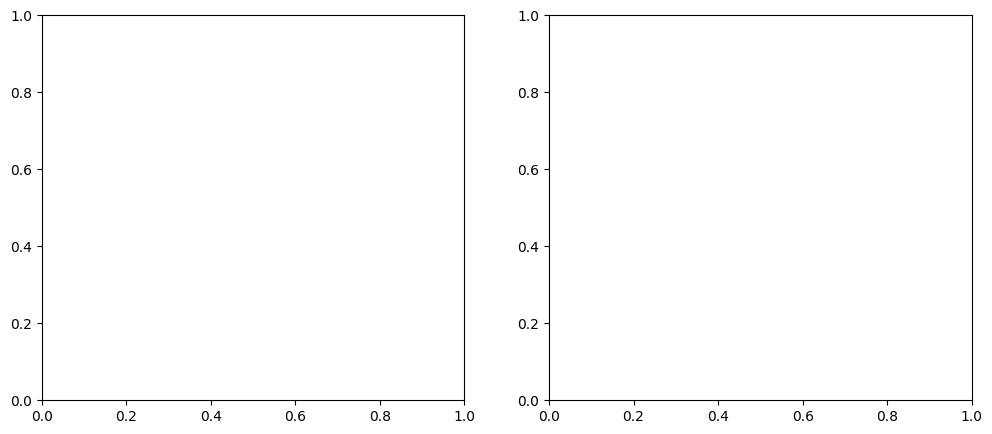

In [31]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

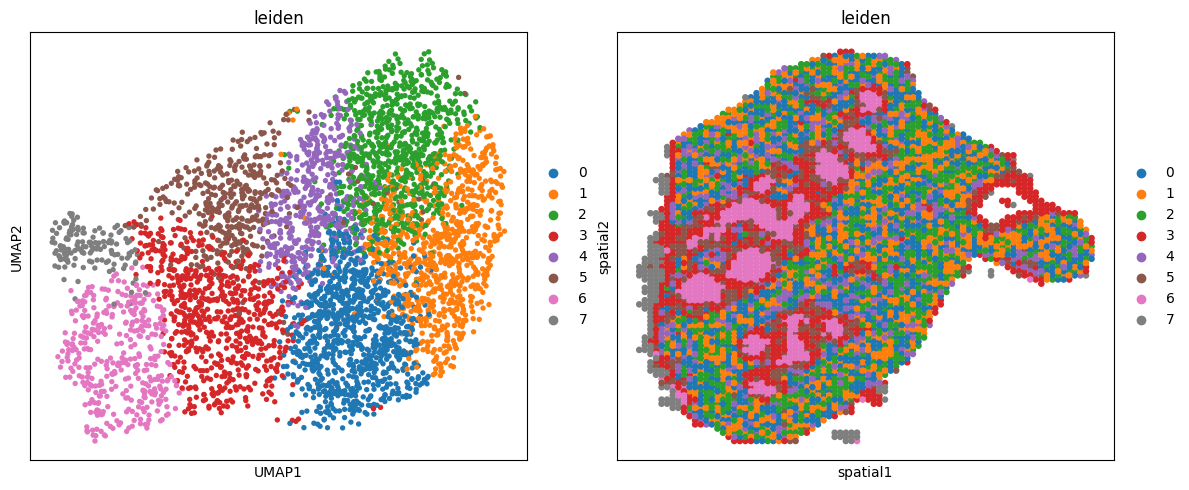

In [32]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='leiden', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='leiden', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

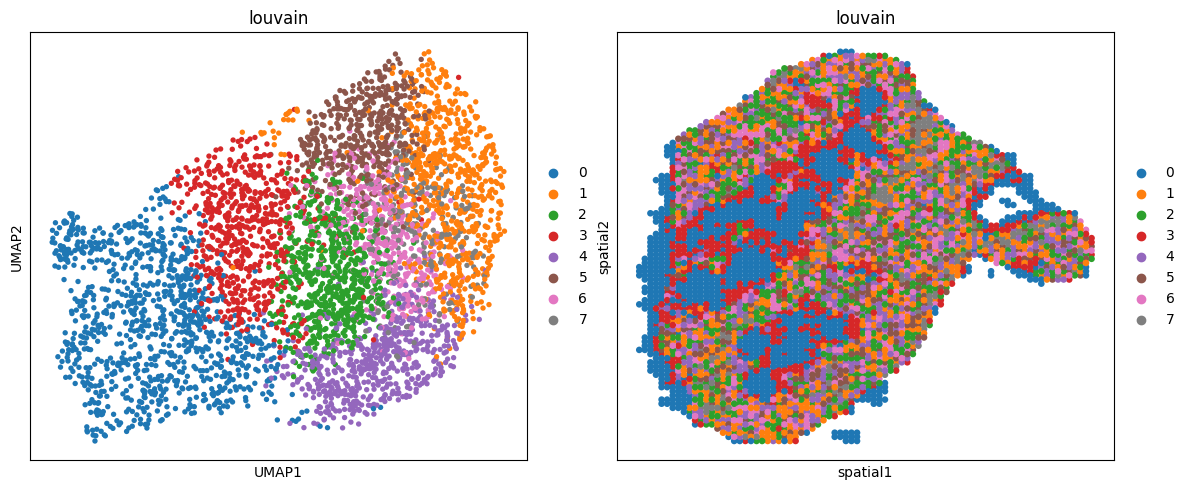

In [33]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='3', ax=ax_list[0], title='louvain', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='3', ax=ax_list[1], title='louvain', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()